<br><font color='green'>
## ch.4 Libraries, Read data(1)

In [1]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#  tf.logging.set_verbosity(tf.logging.ERROR) <- logging이 버전업그레이드에서 사용 X라함

# from tensorflow import set_random_seed 
# 위에 코드 안됨에 대한 답변: In Tensoflow2 there is no need to perform
# from tensorflow import set_random_seed
# in order to run
# set_random_seed(x)
# (as it was in older version)
# Only have to run
# import tensorflow
# tensorflow.random.set_seed(x)

tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

Using TensorFlow backend.


### Read Data(1)

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv')
IDtest = df_test.cust_id.unique()

In [3]:
X_train = pd.read_csv('X_train_after_preprocessing.csv',encoding='cp949')
X_test = pd.read_csv('X_test_after_preprocessing.csv', encoding='cp949')
IDtest = df_test.cust_id.unique()
y_train = pd.read_csv('y_train.csv').gender

### 3. Feature Engineering

<font color="#CC3D3D">*Generate k-means clustering features*

In [4]:
from sklearn.cluster import KMeans

class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:data_with_target.shape[1]-1], 
                          n_init=1, max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points,1]
        """
        clusters = self.km_model.predict(X)
        onehot = self.cluster_encoder.transform(clusters.reshape(-1,1)).toarray()
        max_col = onehot.shape[1]
        pca = PCA(n_components=max_col, random_state=0).fit(onehot)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        num_col = np.argmax(cumsum >= 0.99) + 1
        if num_col == 1: num_col = max_col
        pca = PCA(n_components = num_col, random_state=0).fit_transform(onehot)
        return pd.DataFrame(pca)
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform.
        """
        self.fit(X, y)
        return self.transform(X, y)

In [5]:
# Perform k-means clustering
# 최적의 k와 target_scale 값을 찾아야함.
kmf_hint = KMeansFeaturizer(k=5, target_scale=5, random_state=0).fit(X_train, y_train)
#kmf_no_hint = KMeansFeaturizer(k=30, target_scale=0, random_state=0).fit(train_x, y_train)

# Generate k-means clustering features
training_cluster_features = kmf_hint.transform(X_train)
test_cluster_features = kmf_hint.transform(X_test)

# Augment existing features with the k-means clustering features
X_train = pd.concat([X_train, training_cluster_features], axis=1)
X_test = pd.concat([X_test, test_cluster_features], axis=1)
X_train.columns = range(1, X_train.shape[1]+1)
X_test.columns = range(1, X_test.shape[1]+1)

print(X_train.shape)

(3500, 45)


*Select Features*

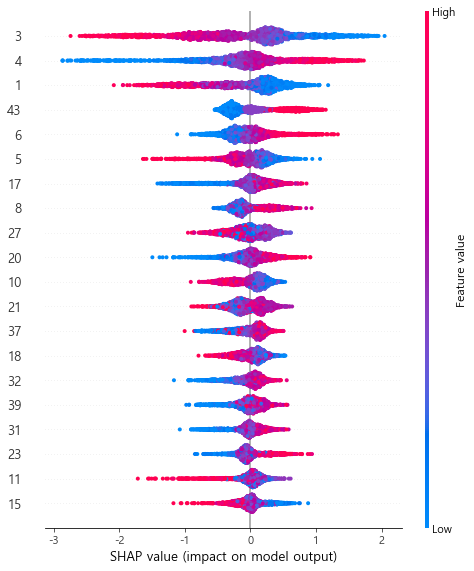

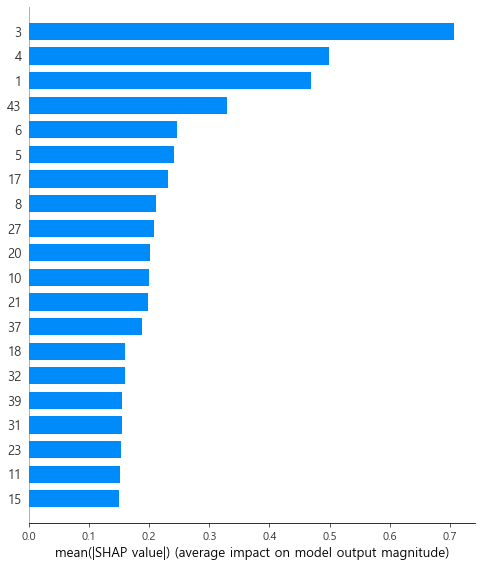

,column_name,shap_importance
2,3.0,0.706316
3,4.0,0.499162
0,1.0,0.468467
42,43.0,0.330088
5,6.0,0.246164
4,5.0,0.241936
16,17.0,0.231173
7,8.0,0.212138
26,27.0,0.208299
19,20.0,0.202277


In [6]:
# Method 2: Using SHAP values

import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = XGBClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

#model = LogisticRegression(random_state=0).fit(train_x, y_train)
#explainer = shap.LinearExplainer(model, train_x, feature_dependence="independent")
#shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:06<00:00, 14.66it/s]


(87, 0.7709335900884187)


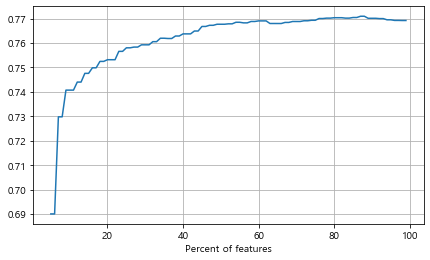

In [7]:
model = LogisticRegression(random_state=0)

cv_scores = []
for p in tqdm(range(5,100,1)):
    nf = int(importance_df.shape[0] * p * 0.01)
    features_selected = importance_df.iloc[:nf].column_name
    X_new = X_train[features_selected]
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.figure(figsize=(7,4))
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [8]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
nf = int(importance_df.shape[0] * best_score[0] * 0.01)
features_selected = importance_df.iloc[:nf].column_name
train_p = X_train[features_selected]
test_p = X_test[features_selected]

### Read Data

In [9]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


### Transform Categorical Data using BOW

In [10]:
level = 'gds_grp_nm'

df_all = pd.concat([df_train, df_test])
train1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'gds_grp_mclas_nm'

df_all = pd.concat([df_train, df_test])
train2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'goods_id'

df_all = pd.concat([df_train, df_test])
train3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

train = np.hstack([train1, train2, train3])
test = np.hstack([test1, test2, test3])

train.shape, test.shape

((3500, 4179), (2482, 4179))

In [11]:
train_ae = pd.DataFrame(train)
test_ae = pd.DataFrame(test)

In [12]:
train = pd.concat([train_p, train_ae], axis=1)
test = pd.concat([test_p, test_ae], axis=1)
train.shape, test.shape

((3500, 4218), (2482, 4218))

In [13]:
train

,3,4,1,43,6,5,17,8,27,20,10,21,37,18,32,39,31,23,11,15,41,9,16,2,12,...,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4167,4168,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178
0,1.123974,0.371957,0.982094,-0.662938,0.662100,-0.769916,-0.404948,-0.877708,0.063438,0.535673,0.275346,0.163501,-0.022980,0.300900,-0.389758,-0.255138,0.116697,-0.070671,0.647643,-0.704409,0.167472,0.064286,0.424851,-0.504664,-0.085274,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.465950,-0.046479,-1.215208,-0.071297,-0.175801,-0.195007,-0.123788,-0.282640,0.002718,-0.166877,-0.381074,-0.024879,0.064715,-0.309818,0.020560,-0.201269,0.046629,0.424455,-0.034089,0.309148,0.013789,0.082884,0.174981,-0.017400,0.193551,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.076139,0.131531,-1.480931,-0.071297,-0.174095,-0.088417,0.282798,-0.022966,0.017764,0.519733,-0.472720,-0.110728,0.148386,-0.199497,-0.078233,0.100983,0.170996,0.275522,0.462877,0.000761,-0.021002,0.687783,-0.408717,-0.081367,0.289197,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.386952,-0.114146,0.048247,-0.662938,0.544103,0.504008,0.569078,0.739678,0.220955,-0.171620,0.362655,0.346603,-0.240842,0.613191,-0.099573,0.117060,-0.201950,-0.066143,-0.202718,0.172811,0.022781,0.615703,-0.502450,-0.668469,0.972889,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.431179,-0.014417,-1.085032,0.745127,-0.196057,-0.395529,-0.062057,0.084428,-0.073429,-0.115687,0.130159,-0.031676,0.347734,-0.105541,0.210413,-0.103501,-0.139000,0.248115,-0.299835,-0.143346,-0.047497,-0.385758,-0.197925,0.444800,0.547423,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,-0.431697,0.371755,-1.354330,0.745127,0.139992,0.059029,-0.209156,0.054583,-0.025671,-0.095592,-0.109492,0.019032,0.295518,-0.381021,-0.014693,-0.010555,0.129682,-0.061996,0.135317,-0.052368,-0.021106,0.555799,0.035836,0.428018,0.052686,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3496,0.132437,0.156816,-0.740669,0.745127,-0.206158,-0.762689,0.156531,0.070968,-0.366505,-0.019906,0.207345,-0.478802,0.178151,-0.040675,0.025969,0.054274,-0.047240,-0.657195,-0.103906,-0.619240,-0.019805,-0.238573,-0.039136,-0.950728,0.304509,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3497,-0.208584,-0.229384,-1.786170,-0.071297,-0.465180,0.199843,-0.047234,0.061877,0.090750,0.173778,-0.118682,0.022927,0.072878,0.049549,-0.108337,0.123293,0.167895,-0.143256,0.466909,-0.113526,-0.009232,0.507629,-0.225544,0.104859,-0.543505,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3498,0.305481,-0.476851,-1.451272,-0.071297,0.389127,0.279872,-0.159663,-0.057624,-0.213462,0.023872,0.332502,-0.472576,0.049020,0.392186,0.027319,-0.049478,0.014281,-0.045724,0.379351,0.131716,-0.013981,-0.201262,-0.270933,0.565601,-0.507074,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
test

,3,4,1,43,6,5,17,8,27,20,10,21,37,18,32,39,31,23,11,15,41,9,16,2,12,...,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4167,4168,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178
0,-0.939580,0.467606,0.176937,0.049292,0.364910,-1.022492,-0.141882,0.943723,0.092843,0.337017,-0.169561,-0.139248,0.018028,-0.015572,0.181031,-0.031151,-0.103695,-0.303149,0.111299,0.278592,0.096215,-0.601764,0.212268,-0.583826,0.171366,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.409589,0.243464,1.012790,0.049292,-0.469563,0.691517,-0.265536,-1.163428,-0.180864,0.015403,0.337713,0.120114,0.052099,0.151192,0.176632,0.072132,-0.003696,0.129763,-1.232221,-0.019365,-0.004869,-0.156748,0.100514,-0.194273,0.015095,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.004245,-0.055749,4.018016,0.055217,-0.034507,0.429428,-0.473586,0.538039,-0.051434,-0.090220,-0.469155,-0.449775,0.056067,0.631463,-0.181229,-0.019419,-0.358421,0.009146,0.322665,-0.500125,0.215177,0.150951,-0.741651,1.173423,0.117449,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0.005766,-0.894329,-0.942564,-0.312965,-0.094914,-0.460378,-0.049327,-0.519387,-0.179444,0.446321,0.101024,-0.539978,-0.226676,0.710599,0.157166,-0.006901,-0.043086,0.302080,0.438507,0.178303,-0.039922,0.495334,0.514736,0.080067,-0.195275,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.119073,0.071123,-1.190258,-0.312965,-0.334674,-0.108039,-0.080503,0.132353,0.238776,0.258588,0.233305,-0.330861,0.087002,0.340837,0.085962,0.107322,0.002919,0.225990,0.764636,0.021642,-0.054699,0.395933,0.371044,0.335129,0.067923,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,-0.494630,0.098872,-0.257353,0.816859,-0.503620,-0.668433,0.489289,-0.212455,-0.051706,0.087173,-0.195961,0.530278,0.093391,0.389829,-0.364759,-0.004674,0.059362,-0.331023,0.231894,-0.312592,-0.053118,-0.231185,0.383768,-0.350982,-0.249089,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2478,0.058093,0.073737,-1.558696,-0.312965,-0.314287,0.225678,-0.086882,-0.169173,0.160061,-0.528279,-0.258874,-0.151528,-0.071914,0.148974,-0.050639,0.055393,0.055693,0.311375,0.382855,0.161380,0.010498,0.924773,0.177850,0.017406,-0.428141,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2479,-1.201388,1.287096,1.205817,0.049292,-0.660860,0.313697,0.119413,0.847918,-0.296596,0.259945,-0.007938,-0.278348,-0.245976,0.544641,0.069294,0.041004,-0.254063,0.317828,-0.984161,0.382973,-0.146145,-0.290314,0.074684,0.329429,-0.468520,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2480,0.218091,0.630052,-0.071931,0.816859,-0.359865,0.435355,0.295777,0.612636,0.044999,-0.145393,0.010140,-0.134091,0.240400,0.299153,0.280329,-0.126512,-0.311932,0.011012,-0.139360,-0.253039,-0.029944,0.067174,-0.323561,1.101739,0.733693,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


DAE learning curve 1번이에여


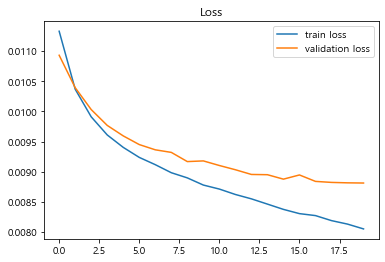

In [15]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []


X_train, X_test = train, test

##### STEP 1: Randomize Seed
SEED = np.random.randint(1, 10000)              
random.seed(SEED)       
np.random.seed(SEED)     
if tf.__version__[0] < '2':  
    tf.set_random_seed(SEED)
else:
    tf.random.set_seed(SEED)

##### STEP 2: Build DAE #####

# Define the encoder dimension
encoding_dim = 128

# Input Layer
input_dim = Input(shape = (X_train.shape[1], ))

# Encoder Layers
noise = Dropout(0.5)(input_dim) # for Denoising
encoded1 = Dense(512, activation = 'relu')(noise)
encoded2 = Dense(256, activation = 'relu')(encoded1)
encoded3 = Dense(128, activation = 'relu')(encoded2)
encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

# Decoder Layers
decoded1 = Dense(128, activation = 'relu')(encoded4)
decoded2 = Dense(256, activation = 'relu')(decoded1)
decoded3 = Dense(512, activation = 'relu')(decoded2)
decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded4)

# Compile the model
autoencoder.compile(optimizer = 'adam', loss = 'mse')

# Train the model
history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

print(f'DAE learning curve 1번이에여')
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

##### STEP 3: Reduce Dimension #####
        
# Use a middle Bottleneck Layer to Reduce Dimension
model = Model(inputs=input_dim, outputs=encoded4)
X_train = model.predict(X_train)
X_test = model.predict(X_test)

In [16]:
X_train.shape, X_test.shape

((3500, 128), (2482, 128))

In [17]:
X_train = pd.DataFrame(X_train)
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.0,0.000000,0.752783,0.0,0.0,0.000000,0.404841,0.000000,0.179805,0.116839,0.0,0.0,0.000000,0.0,0.439499,0.0,0.000000,0.000000,0.445949,0.0,0.235081,0.385657,0.000000,0.0,0.0,...,0.271377,0.255971,0.0,0.387138,0.0,0.00000,0.0,0.0,0.143218,0.0,0.204032,0.680721,0.587746,0.621949,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.967016,0.821273,1.263841,0.497209
1,0.0,0.000000,0.066825,0.0,0.0,0.000000,0.000000,0.000000,0.173691,0.000000,0.0,0.0,0.000000,0.0,0.074186,0.0,0.130571,0.000000,0.040675,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.212304,0.0,0.00000,0.0,0.0,0.000000,0.0,0.007213,0.000000,0.204510,0.000000,0.000000,0.0,0.0,0.0,0.0,0.026893,0.0,0.005489,0.184758,0.141519,0.000000
2,0.0,0.195168,0.044434,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.054214,0.0,0.0,0.051384,0.0,0.103537,0.0,0.000000,0.002283,0.047103,0.0,0.128517,0.000000,0.000000,0.0,0.0,...,0.007537,0.043846,0.0,0.144065,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000005,0.123516,0.167019,0.012901,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.103648,0.094426,0.298023,0.000000
3,0.0,0.317967,0.261595,0.0,0.0,0.000000,0.000000,0.000000,0.480665,0.000000,0.0,0.0,0.365112,0.0,0.198715,0.0,0.000000,0.000000,0.705219,0.0,0.531491,0.280980,0.000000,0.0,0.0,...,0.000000,0.007329,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.130230,0.369607,0.245074,0.375512,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.694752,0.332083,0.666578,0.100159
4,0.0,0.235115,0.136975,0.0,0.0,0.000000,0.000000,0.000000,0.037786,0.000000,0.0,0.0,0.000000,0.0,0.160818,0.0,0.108505,0.000000,0.000000,0.0,0.000000,0.000000,0.009196,0.0,0.0,...,0.089545,0.086617,0.0,0.181202,0.0,0.00000,0.0,0.0,0.039422,0.0,0.176358,0.021707,0.259954,0.000000,0.096835,0.0,0.0,0.0,0.0,0.106906,0.0,0.111857,0.048718,0.084523,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.0,0.243816,0.125174,0.0,0.0,0.000000,0.002837,0.000000,0.129302,0.000000,0.0,0.0,0.069061,0.0,0.147099,0.0,0.154673,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.082727,0.008736,0.0,0.199804,0.0,0.00000,0.0,0.0,0.000000,0.0,0.034961,0.192119,0.265232,0.045709,0.076969,0.0,0.0,0.0,0.0,0.000000,0.0,0.052399,0.000000,0.112465,0.000000
3496,0.0,0.269085,0.375453,0.0,0.0,0.000000,0.000000,0.174544,0.116254,0.000000,0.0,0.0,0.000000,0.0,0.293123,0.0,0.000000,0.000000,0.288130,0.0,0.136959,0.000000,0.000000,0.0,0.0,...,0.116578,0.000000,0.0,0.229995,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.106421,0.324450,0.000000,0.003900,0.0,0.0,0.0,0.0,0.000000,0.0,0.464474,0.144902,0.271848,0.052902
3497,0.0,0.000000,0.000000,0.0,0.0,0.026852,0.000000,0.045447,0.076197,0.054017,0.0,0.0,0.001023,0.0,0.117204,0.0,0.000000,0.000000,0.055297,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.031647,0.078741,0.083145,0.078409,0.006501,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.052382,0.000000,0.000000
3498,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.045570,0.027434,0.0,0.0,0.000000,0.0,0.053350,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.149178,0.017506,0.0,0.051236,0.0,0.02612,0.0,0.0,0.136553,0.0,0.125582,0.023739,0.153848,0.061856,0.030046,0.0,0.0,0.0,0.0,0.183835,0.0,0.036845,0.088136,0.009595,0.000000


In [18]:
X_test = pd.DataFrame(X_test)
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.0,0.000000,0.313210,0.0,0.0,0.0,0.000000,0.000000,0.480203,0.000000,0.0,0.0,0.000000,0.0,0.123357,0.0,0.237180,0.0,0.024457,0.0,0.000000,0.002588,0.000000,0.0,0.0,...,0.057398,0.092774,0.0,0.758637,0.0,0.0,0.0,0.0,0.000000,0.0,0.139707,0.000000,0.594848,0.268704,0.000000,0.0,0.0,0.0,0.00000,0.042904,0.0,0.619288,0.577739,0.713107,0.000000
1,0.0,0.000000,0.475666,0.0,0.0,0.0,0.000000,0.000000,0.942760,0.000000,0.0,0.0,0.199815,0.0,0.273568,0.0,0.288285,0.0,1.159606,0.0,0.000000,0.067453,0.000000,0.0,0.0,...,0.000000,1.081346,0.0,0.426368,0.0,0.0,0.0,0.0,0.568012,0.0,0.000000,0.457992,0.126356,0.049386,0.288727,0.0,0.0,0.0,0.00000,0.000000,0.0,0.508926,0.399947,0.077365,0.000000
2,0.0,0.000000,0.673565,0.0,0.0,0.0,0.000000,0.000000,3.136467,1.047400,0.0,0.0,1.045569,0.0,0.000000,0.0,0.026302,0.0,2.521183,0.0,0.000000,0.824842,0.000000,0.0,0.0,...,0.000000,1.676778,0.0,0.651151,0.0,0.0,0.0,0.0,1.970095,0.0,0.879457,1.247037,1.918088,2.604684,2.780520,0.0,0.0,0.0,0.00000,0.000000,0.0,0.805923,1.556694,1.232336,2.487576
3,0.0,0.000000,0.166370,0.0,0.0,0.0,0.080912,0.000000,0.070133,0.000000,0.0,0.0,0.170894,0.0,0.336785,0.0,0.027811,0.0,0.136545,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.138779,0.0,0.196743,0.0,0.0,0.0,0.0,0.062836,0.0,0.095941,0.166543,0.492026,0.184131,0.206552,0.0,0.0,0.0,0.00000,0.046220,0.0,0.000000,0.364918,0.118973,0.002973
4,0.0,0.096960,0.070528,0.0,0.0,0.0,0.000000,0.000000,0.159734,0.000000,0.0,0.0,0.152368,0.0,0.181056,0.0,0.091393,0.0,0.111164,0.0,0.081986,0.000000,0.000000,0.0,0.0,...,0.000000,0.182541,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.214493,0.067071,0.506599,0.157814,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.117292,0.431910,0.250046,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,0.0,0.000000,0.107625,0.0,0.0,0.0,0.267140,0.000000,0.399263,0.120895,0.0,0.0,0.000000,0.0,0.142890,0.0,0.125040,0.0,0.171376,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.049459,0.229787,0.0,0.666397,0.0,0.0,0.0,0.0,0.374968,0.0,0.000000,0.196319,0.151752,0.192463,0.083638,0.0,0.0,0.0,0.00000,0.000000,0.0,0.226785,0.284670,0.468092,0.005939
2478,0.0,0.000000,0.087403,0.0,0.0,0.0,0.014460,0.125615,0.129678,0.077074,0.0,0.0,0.000000,0.0,0.034982,0.0,0.000000,0.0,0.099289,0.0,0.000000,0.000000,0.018764,0.0,0.0,...,0.111494,0.048446,0.0,0.050420,0.0,0.0,0.0,0.0,0.001395,0.0,0.000000,0.172430,0.057924,0.041943,0.000000,0.0,0.0,0.0,0.01681,0.000000,0.0,0.000000,0.019164,0.000000,0.032595
2479,0.0,0.000000,0.727501,0.0,0.0,0.0,0.230307,0.000000,1.489481,0.228519,0.0,0.0,0.216606,0.0,0.440747,0.0,0.538669,0.0,0.507163,0.0,0.000000,0.244584,0.000000,0.0,0.0,...,0.000000,0.949033,0.0,1.328629,0.0,0.0,0.0,0.0,0.715347,0.0,0.430520,0.000000,0.393706,0.145740,0.420379,0.0,0.0,0.0,0.00000,0.000000,0.0,1.284763,0.528800,0.956225,0.000000
2480,0.0,0.074154,0.226372,0.0,0.0,0.0,0.000000,0.000000,0.460062,0.011743,0.0,0.0,0.189767,0.0,0.332602,0.0,0.275751,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.333588,0.0,0.000000,0.0,0.0,0.0,0.0,0.060231,0.0,0.410654,0.000000,0.166261,0.000000,0.022849,0.0,0.0,0.0,0.00000,0.000000,0.0,0.198375,0.390258,0.306704,0.000000


## conv2d로 뽑아낸 feature 적용.

In [19]:
X_test_cnn2 = pd.read_csv('X_test_cnn2.csv', encoding='cp949', index_col=0)
X_train_cnn2 = pd.read_csv('X_train_cnn2.csv', encoding='cp949', index_col=0)

In [20]:
X_train = pd.concat([X_train, X_train_cnn2], axis=1)
X_test = pd.concat([X_test, X_test_cnn2], axis=1)

In [21]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,cnn2_nm,cnn2_mclas,cnn2_goods
0,0.0,0.000000,0.752783,0.0,0.0,0.000000,0.404841,0.000000,0.179805,0.116839,0.0,0.0,0.000000,0.0,0.439499,0.0,0.000000,0.000000,0.445949,0.0,0.235081,0.385657,0.000000,0.0,0.0,...,0.387138,0.0,0.00000,0.0,0.0,0.143218,0.0,0.204032,0.680721,0.587746,0.621949,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.967016,0.821273,1.263841,0.497209,0.167310,0.118997,0.102176
1,0.0,0.000000,0.066825,0.0,0.0,0.000000,0.000000,0.000000,0.173691,0.000000,0.0,0.0,0.000000,0.0,0.074186,0.0,0.130571,0.000000,0.040675,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.212304,0.0,0.00000,0.0,0.0,0.000000,0.0,0.007213,0.000000,0.204510,0.000000,0.000000,0.0,0.0,0.0,0.0,0.026893,0.0,0.005489,0.184758,0.141519,0.000000,0.561523,0.576015,0.479404
2,0.0,0.195168,0.044434,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.054214,0.0,0.0,0.051384,0.0,0.103537,0.0,0.000000,0.002283,0.047103,0.0,0.128517,0.000000,0.000000,0.0,0.0,...,0.144065,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000005,0.123516,0.167019,0.012901,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.103648,0.094426,0.298023,0.000000,0.545812,0.595677,0.496705
3,0.0,0.317967,0.261595,0.0,0.0,0.000000,0.000000,0.000000,0.480665,0.000000,0.0,0.0,0.365112,0.0,0.198715,0.0,0.000000,0.000000,0.705219,0.0,0.531491,0.280980,0.000000,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.130230,0.369607,0.245074,0.375512,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.694752,0.332083,0.666578,0.100159,0.329218,0.333982,0.492453
4,0.0,0.235115,0.136975,0.0,0.0,0.000000,0.000000,0.000000,0.037786,0.000000,0.0,0.0,0.000000,0.0,0.160818,0.0,0.108505,0.000000,0.000000,0.0,0.000000,0.000000,0.009196,0.0,0.0,...,0.181202,0.0,0.00000,0.0,0.0,0.039422,0.0,0.176358,0.021707,0.259954,0.000000,0.096835,0.0,0.0,0.0,0.0,0.106906,0.0,0.111857,0.048718,0.084523,0.000000,0.438546,0.405885,0.433425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.0,0.243816,0.125174,0.0,0.0,0.000000,0.002837,0.000000,0.129302,0.000000,0.0,0.0,0.069061,0.0,0.147099,0.0,0.154673,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.199804,0.0,0.00000,0.0,0.0,0.000000,0.0,0.034961,0.192119,0.265232,0.045709,0.076969,0.0,0.0,0.0,0.0,0.000000,0.0,0.052399,0.000000,0.112465,0.000000,0.507663,0.520769,0.509415
3496,0.0,0.269085,0.375453,0.0,0.0,0.000000,0.000000,0.174544,0.116254,0.000000,0.0,0.0,0.000000,0.0,0.293123,0.0,0.000000,0.000000,0.288130,0.0,0.136959,0.000000,0.000000,0.0,0.0,...,0.229995,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.106421,0.324450,0.000000,0.003900,0.0,0.0,0.0,0.0,0.000000,0.0,0.464474,0.144902,0.271848,0.052902,0.422339,0.384672,0.572425
3497,0.0,0.000000,0.000000,0.0,0.0,0.026852,0.000000,0.045447,0.076197,0.054017,0.0,0.0,0.001023,0.0,0.117204,0.0,0.000000,0.000000,0.055297,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.031647,0.078741,0.083145,0.078409,0.006501,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.052382,0.000000,0.000000,0.484371,0.474457,0.470807
3498,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.045570,0.027434,0.0,0.0,0.000000,0.0,0.053350,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.051236,0.0,0.02612,0.0,0.0,0.136553,0.0,0.125582,0.023739,0.153848,0.061856,0.030046,0.0,0.0,0.0,0.0,0.183835,0.0,0.036845,0.088136,0.009595,0.000000,0.402724,0.406019,0.417161


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DNN learning curve 1/10


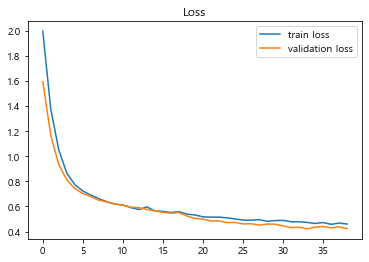

AUC 0.9034853491958581


 10%|████████▎                                                                          | 1/10 [00:03<00:30,  3.39s/it]

DNN learning curve 2/10


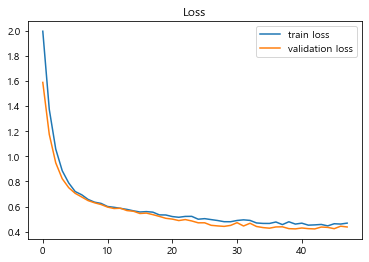

 20%|████████████████▌                                                                  | 2/10 [00:07<00:28,  3.52s/it]

AUC 0.9029728944490019
DNN learning curve 3/10


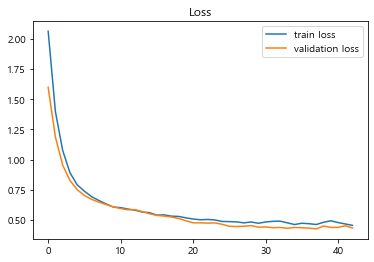

 30%|████████████████████████▉                                                          | 3/10 [00:10<00:24,  3.48s/it]

AUC 0.9012877005347594
DNN learning curve 4/10


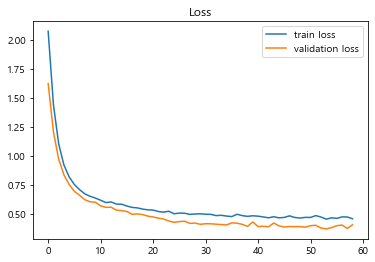

AUC 0.9258255084716399


 40%|█████████████████████████████████▏                                                 | 4/10 [00:14<00:22,  3.75s/it]

DNN learning curve 5/10


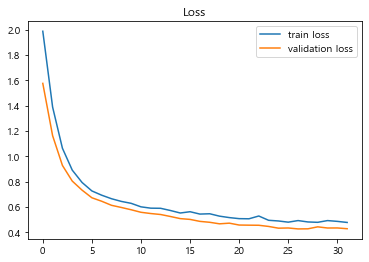

AUC 0.9137271382169342


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:17<00:17,  3.46s/it]

DNN learning curve 6/10


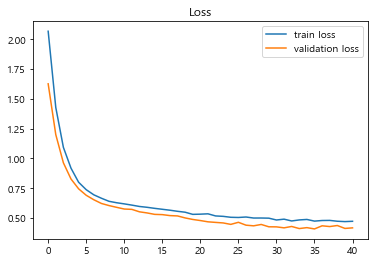

AUC 0.9206544281434825


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:21<00:14,  3.51s/it]

DNN learning curve 7/10


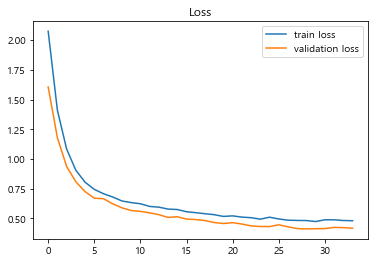

AUC 0.9099422787728161


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:24<00:10,  3.43s/it]

DNN learning curve 8/10


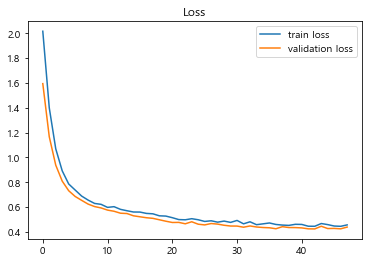

AUC 0.8974855776363907


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:28<00:07,  3.59s/it]

DNN learning curve 9/10


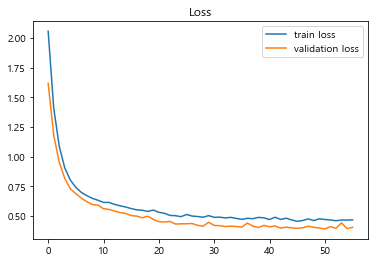

AUC 0.9159381244647445


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:33<00:03,  3.94s/it]

DNN learning curve 10/10


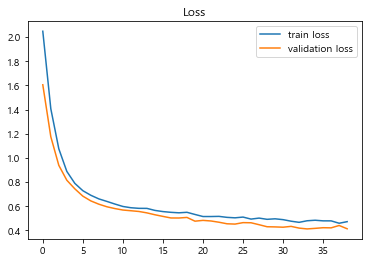

AUC 0.9144078398665554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.66s/it]


Validation Summary:
3    0.925826
5    0.920654
8    0.915938
9    0.914408
4    0.913727
6    0.909942
0    0.903485
1    0.902973
2    0.901288
7    0.897486
dtype: float64
mean=0.91057, std=0.009


In [22]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):   
    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)))
    model.add(Dropout(0.6))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

In [40]:
print()

In [24]:
N = 10
p = 3.5

# Power mean ensemble
THRESHOLD = 0.77  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file
t = pd.Timestamp.now()
fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dae_p3.5n5_submit_06132048.csv' is ready to submit.


In [25]:
dae_3_5 = pd.read_csv('dae_p3.5n5_submit_06132048.csv')

In [26]:
dae_3_5.isnull().any()

cust_id    False
gender     False
dtype: bool